# AutoInt example

## Imports

### A bunch of third-party libraries

In [1]:
!pip install torch
import torch
import matplotlib.pyplot as plt
import numpy as np
!pip install torchmeta==1.4.6
!pip install colour

from torchmeta.modules import MetaModule
from functools import partial
from torch.utils.data import DataLoader

### Our libraries

In [17]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import sys
import os
sys.path.append(os.path.abspath('/content/gdrive/My Drive/'))


from autoint_python.session import Session
import autoint_python.autograd_modules as autoint

Mounted at /content/gdrive/


## A class to create coordinates from a 1D function we wish to fit

In [18]:
class Implicit1DWrapper(torch.utils.data.Dataset):
    def __init__(self, range, fn, grad_fn=None, integral_fn=None, sampling_density=100,
                 train_every=10):

        avg = (range[0] + range[1]) / 2

        coords = self.get_samples(range, sampling_density)
        self.fn_vals = fn(coords)
        self.train_idx = torch.arange(0, coords.shape[0], train_every).float()

        #coords = (coords - avg) / (range[1] - avg)
        self.grid = coords
        self.grid.requires_grad_(True)
        #self.val_grid = val_coords

        if grad_fn is None:
            grid_gt_with_grad = coords
            grid_gt_with_grad.requires_grad_(True)
            fn_vals_with_grad = fn((grid_gt_with_grad * (range[1] - avg)) + avg)
            gt_gradient = torch.autograd.grad(fn_vals_with_grad, [grid_gt_with_grad],
                                              grad_outputs=torch.ones_like(grid_gt_with_grad), create_graph=True,
                                              retain_graph=True)[0]
            try:
                gt_hessian = torch.autograd.grad(gt_gradient, [grid_gt_with_grad],
                                                 grad_outputs=torch.ones_like(gt_gradient), retain_graph=True)[0]
            except Exception as e:
                gt_hessian = torch.zeros_like(gt_gradient)

        else:
            gt_gradient = grad_fn(coords) 
            gt_hessian = torch.zeros_like(gt_gradient)

        self.integral_fn = integral_fn
        if integral_fn:
            self.integral_vals = integral_fn(coords)

        self.gt_gradient = gt_gradient.detach()
        self.gt_hessian = gt_hessian.detach()

    def get_samples(self, range, sampling_density):
        num = int(range[1] - range[0])*sampling_density
        avg = (range[0] + range[1]) / 2
        coords = np.linspace(start=range[0], stop=range[1], num=num)
        coords.astype(np.float32)
        coords = torch.Tensor(coords).view(-1, 1)
        return coords

    def get_num_samples(self):
        return self.grid.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if self.integral_fn is not None:
            return {'coords':self.grid}, {'integral_func': self.integral_vals, 'func':self.fn_vals,
                    'gradients':self.gt_gradient, 'val_func': self.val_fn_vals,
                    'val_coords': self.val_grid, 'hessian':self.gt_hessian}
        else:
            return {'idx': self.train_idx, 'coords':self.grid}, \
                   {'func': self.fn_vals, 'gradients':self.gt_gradient,
                    'coords': self.grid}

## Different 1D functions we want to integrate

In [19]:
def cos_fn(coords):
  return torch.cos(10*coords)

def polynomial_fn(coords):
    return .1*coords**5 - .2*coords**4 + .2*coords**3 - .4*coords**2 + .1*coords

def sinc_fn(coords):
    coords[coords == 0] += 1
    return torch.div(torch.sin(20*coords), 20*coords)

def linear_fn(coords):
    return 1.0 * coords

def xcosx_fn(coords):
    return coords * torch.cos(coords)

def integral_xcosx_fn(coords):
    return coords*torch.sin(coords) + torch.cos(coords)

## Setting up the integral network & the grad network

We define an integral network using the AutoInt API. Here the integral network is a MLP with sine non-linearities: a SIREN.

In [20]:
class SIREN(MetaModule):
    def __init__(self, session):
        super().__init__()

        self.net = [] 
        self.input = autoint.Input(torch.Tensor(1, 1), id='x_coords')
        #self.constant = autoint.Constant(torch.Tensor(1, 1), id='y_coords')

        self.net.append(autoint.Linear(1, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 1))

        self.net = torch.nn.Sequential(*self.net)
        self.session = session

    def input_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Input):
                m.set_value(input_tensor, grad=True)

    def constant_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Constant):
                m.set_value(input_tensor, grad=False)
    
    def forward(self, x):
        with torch.no_grad():
            input_init_func = partial(self.input_init, x[:, 0, None])
            #constant_init_func = partial(self.constant_init, x[:, 1, None])
            self.input.apply(input_init_func)
            #self.constant.apply(constant_init_func)

        input_ctx = autoint.Value(x, self.session)

        out1 = self.input(input_ctx)
        #out2 = self.constant(input_ctx)

        #out = autoint.Concatenate()(out1, out2)
        return self.net(out1)#, self.input.input

In AutoInt, a session will handle the derivation of the integral network into the grad network for you. It takes care of the reassembly of the weights too.

In [21]:
integralnet_session = Session()

Creating session: 8788107720729


We instantiate the integral net we defined earlier. The session can be thought as representing the integral network.

In [22]:
net = SIREN(integralnet_session)

We can evaluate the SIREN we instantiated using the forward function as we would do for any Pytorch module.

In [23]:
x = torch.ones(1, 1) # defines a dummy input
y = torch.ones(1, 1)
x.requires_grad_(True)

session_input = {'x_coords': x,
                 #'y_coords': y,
                 'params': None}

y = net(x)

forward_siren_evaluation = y.data
print(f"result of forward SIREN evaluation={forward_siren_evaluation}")

result of forward SIREN evaluation=tensor([[0.0115]], grad_fn=<AddBackward0>)


Evaluating the session also yields the output of the network. We must evaluate the session at least once (as done above) to initialize the session properly and get the backward session

In [24]:
integralnet_session_evaluation = integralnet_session(session_input)
print(f"result of forward session evaluation={integralnet_session_evaluation}")

result of forward session evaluation=tensor([[0.0115]], grad_fn=<AddBackward0>)


We can check the two evaluations (the evaluation of the integral network via forward and of the session representing the integral network) are the same

In [25]:
error_fn = torch.nn.MSELoss()
print(f"Error between session and network evaluation={error_fn(forward_siren_evaluation.squeeze(), \
                                                               integralnet_session_evaluation.squeeze())}")

Error between session and network evaluation=0.0


Calling the function get_backward_graph() on the session instantiates another session that represents the grad network. **(this can only be done if the network has been run once!)**



In [26]:
gradnet_session = integralnet_session.get_backward_graph()

Creating session: 8788107720849


We can visualize the integral network we created (by visualizing its associated session)

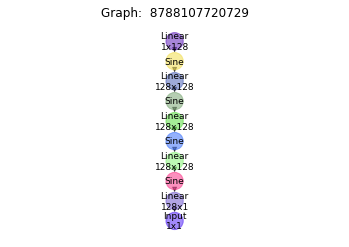

In [27]:
integralnet_session.draw()

We can also visualize the grad network (contained in the back session):

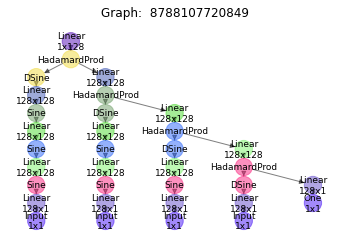

In [28]:
gradnet_session.draw()

## Fitting the grad network

We choose the function we want to calculate the integral using AutoInt.

In [29]:
func_to_fit = cos_fn

We create the dataloader that will create the pairs of datapoints of the form (input coordinate, output of the function to integrate) for us.

In [30]:
dataset = Implicit1DWrapper([-1,1], fn=func_to_fit, \
                            sampling_density=1000, train_every=1)
dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                        pin_memory=True, num_workers=0)

A minimal example of a training loop to fit the function:

In [31]:
epochs = 500

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr=5e-5, params=net.parameters(),amsgrad=True)

print_loss_every = 50

for e in range(epochs):
  for step, (input, gt) in enumerate(dataloader):
      gradnet_output = gradnet_session.compute_graph_fast({'x_coords': input['coords'],
                                                           'params': None})
      loss = loss_fn(gradnet_output,gt['func']).mean()

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
    
  if not e % print_loss_every:
      print(f"{e}/{epochs}: loss={loss}")

0/500: loss=0.5234070420265198
50/500: loss=0.00019768220954574645
100/500: loss=6.490908162959386e-06
150/500: loss=2.939979367511114e-06
200/500: loss=2.0951658825651975e-06
250/500: loss=1.609625087439781e-06
300/500: loss=1.304736088059144e-06
350/500: loss=0.00010830091196112335
400/500: loss=1.6591210396654787e-06
450/500: loss=1.107814227907511e-06


Text(0.5, 1.0, 'Blue=The function to integrate, Cyan=Its fit, Red=Its integral')

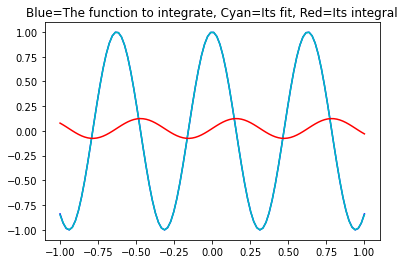

In [32]:
x_coords = torch.linspace(-1,1,100)[:,None]
grad_vals = func_to_fit(x_coords)
fitted_grad_vals = gradnet_session.compute_graph_fast({'x_coords': x_coords,
                                                       'params': None})
integral_vals = integralnet_session.compute_graph_fast({'x_coords': x_coords,
                                                        'params': None})

plt.plot(x_coords,grad_vals,'-b')
plt.plot(x_coords,fitted_grad_vals.detach(),'-c')
plt.plot(x_coords,integral_vals.detach(),'-r')
plt.title("Blue=The function to integrate, Cyan=Its fit, Red=Its integral")
